In [1]:
import sys
import os
import pandas as pd
import numpy as np

In [2]:
from sklearn.feature_extraction import DictVectorizer

In [3]:
in_path = '/home/user/ellendorff/ellendorff_clfiles/PSYMINE/disordercheck/all_term_cands.features.tsv'
term_cands = pd.read_csv(in_path, sep='\t')
print(term_cands.label.value_counts())
#term_cands.head()

neg    1314
pos     257
Name: label, dtype: int64


In [4]:
# bring df columns into correct format

term_cands['term'] = term_cands['term'].apply(lambda x: x.split('|'))
term_cands['preferred_term'] = term_cands['preferred_term'].apply(lambda x: x.split('|'))
term_cands['original_resource'] = term_cands['original_resource'].apply(lambda x: x.split('|'))
term_cands['TTY'] = term_cands['TTY'].apply(lambda x: x.split('|'))
term_cands['umls_semtype'] = term_cands['umls_semtype'].apply(lambda x: x.split('|'))
term_cands['umls_cui'] = term_cands['umls_cui'].apply(lambda x: x.split('|'))
term_cands['punct'] = term_cands['punct'].astype('str').apply(lambda x: x.split('|'))
term_cands['char-2gram'] = term_cands['char-2gram'].astype('str').apply(lambda x: x.split('|'))
term_cands['char-3gram'] = term_cands['char-3gram'].astype('str').apply(lambda x: x.split('|'))
term_cands['fasttext'] = term_cands['fasttext'].astype('str').apply(lambda x: x.strip('\n').split('|'))
term_cands['pos_list'] = term_cands['pos_list'].astype('str').apply(lambda x: x.split('|'))

In [5]:
# use index as identifiers for instances

term_cands = term_cands.reset_index()
term_cands = term_cands.rename(index=str, columns={'index':'id'})
term_cands['id'] = term_cands.id.astype('str')

term_cands.head()

,level_0,id,term_candidate,term,preferred_term,entity_type,original_resource,umls_cui,umls_semtype,TTY,...,char-3gram,pos_list,is_pref,obsolete_tty,abbrev_tty,pref_tty,tty_removable_obsolete,tty_removable_abbrev,tty_removable,num_synsets
0,0,0,(basc-2) depression scale,[depression scale (basc-2)],[Depression Scale (BASC-2)],FOCUS_PSYCHIATRIC_DISORDER,[MTH],[C4049644],[Intellectual Product],[PN],...,"[(ba, bas, asc, sc-, c-2, -2), 2) , ) d, de, ...","[PUNCT, PROPN, PUNCT, NOUN, NOUN]",0,False,False,True,False,False,False,1
1,1,1,(basc-2) scale depression,[depression scale (basc-2)],[Depression Scale (BASC-2)],FOCUS_PSYCHIATRIC_DISORDER,[MTH],[C4049644],[Intellectual Product],[PN],...,"[(ba, bas, asc, sc-, c-2, -2), 2) , ) s, sc, ...","[PUNCT, PROPN, PUNCT, NOUN, NOUN]",0,False,False,True,False,False,False,1
2,2,2,(diagnosis) acrophobia,[acrophobia (diagnosis)],[Fear of heights],FOCUS_PSYCHIATRIC_DISORDER,[MEDCIN],[C0233701],[Mental or Behavioral Dysfunction],[FN],...,"[(di, dia, iag, agn, gno, nos, osi, sis, is), ...","[PUNCT, NOUN, PUNCT, NOUN]",0,False,False,True,False,False,False,1
3,3,3,(diagnosis) agoraphobia,[agoraphobia (diagnosis)],[Agoraphobia],FOCUS_PSYCHIATRIC_DISORDER,[MEDCIN],[C0001818],[Mental or Behavioral Dysfunction],[FN],...,"[(di, dia, iag, agn, gno, nos, osi, sis, is), ...","[PUNCT, NOUN, PUNCT, NOUN]",0,False,False,True,False,False,False,1
4,4,4,(diagnosis) anxiety disorder,[anxiety disorder (diagnosis)],[Anxiety Disorders],FOCUS_PSYCHIATRIC_DISORDER,[MEDCIN],[C0003469],[Mental or Behavioral Dysfunction],[FN],...,"[(di, dia, iag, agn, gno, nos, osi, sis, is), ...","[PUNCT, NOUN, PUNCT, NOUN, NOUN]",0,False,False,True,False,False,False,1


In [6]:
list(term_cands.columns)

['level_0',
 'id',
 'term_candidate',
 'term',
 'preferred_term',
 'entity_type',
 'original_resource',
 'umls_cui',
 'umls_semtype',
 'TTY',
 'token_number',
 'label',
 'num_chars',
 'punct',
 'term_freq',
 'is_np',
 'part_of_np',
 'pref_lvsht',
 'cos_sim',
 'fasttext',
 'char-2gram',
 'char-3gram',
 'pos_list',
 'is_pref',
 'obsolete_tty',
 'abbrev_tty',
 'pref_tty',
 'tty_removable_obsolete',
 'tty_removable_abbrev',
 'tty_removable',
 'num_synsets']

In [7]:
def row_feat_dict(row, ngrams=True):
    '''
    ngrams: include or exclude ngram features
    '''

    feat_dict = dict()  # dictionary for one training instance
    
#     ###### UMLS FEATURES ############
    
    # original resources features
    org_res = {'source:'+i:1 for i in row.original_resource}
    feat_dict.update(org_res)
    
    # tty features
    tty_res = {'tty:'+i:1 for i in row.TTY}
    feat_dict.update(tty_res)
    
    # tty category features
    tty_abbrev_res = {'abbrev_tty:'+str(row.abbrev_tty):1}
    tty_obsolete_res = {'obsolete_tty:'+str(row.obsolete_tty):1}
    tty_pref_res = {'pref_tty:'+str(row.pref_tty):1}
    feat_dict.update(tty_abbrev_res)
    feat_dict.update(tty_obsolete_res)
    feat_dict.update(tty_pref_res)
    
    # is preferred term
    pref_res = {'is_pref': int(row.is_pref)}
    feat_dict.update(pref_res)
    
    # cos sim feature
    cos_sim = {'cosine similarity': round(row.cos_sim,3)}
    feat_dict.update(cos_sim)
    
    # levenshtein distance from preferred term feature
    pref_lvsht = {'Levenshtein': int(row.pref_lvsht)}
    feat_dict.update(pref_lvsht)
    
    # num synsets associated
    num_syn = {'num_synsets': int(row.num_synsets)}
    feat_dict.update(num_syn)
    
    ###### LOCAL FEATURES ############
    
    # punctuation features
    punct_res = {'punct:'+ i:1 for i in row.punct}
    feat_dict.update(punct_res)
    
    # token number feature
    tok_num = {'number tokens': int(row.token_number)}
    feat_dict.update(tok_num)
    
    # character number feature
    char_num = {'number characters': int(row.num_chars)}
    feat_dict.update(char_num)
    
    # pos feature (maps sub-token position to its part-of-speech tag)
    pos_res = {'pos number' + str(pos_i+1):pos for pos_i, pos in enumerate(row['pos_list'])}
    feat_dict.update(pos_res)
    
    if ngrams is True:
        # char-ngram features (maps ngram to ngram count)
        ngram_res_2 = {'|'.join(['2gram:',str(i)]):row['term_candidate'].count(str(i)) for i in row['char-2gram']}
        feat_dict.update(ngram_res_2)
        ngram_res_3 = {'|'.join(['3gram:',str(i)]):row['term_candidate'].count(str(i)) for i in row['char-3gram']}
        feat_dict.update(ngram_res_3)
    
#     ###### DATASET FEATURES ############
    
    # term frequency (in 10 T random abstracts of DS1)
    term_freq = {'term frequency': int(row.term_freq)}
    feat_dict.update(term_freq)
    
    # is (normalized) np feature
    np_res = {'is np:'+ row.is_np:1}
    feat_dict.update(np_res)
    
    # is part of (normalized) np feature
    np_part_res = {'part of np:' + row.part_of_np:1} # one hot encoding of np class
    feat_dict.update(np_part_res)
    
    
    return feat_dict
                                         

In [8]:
term_cands.label.value_counts()

neg    1314
pos     257
Name: label, dtype: int64

In [9]:
ngrams=False

term_cands_feats = term_cands.apply(lambda x: row_feat_dict(x, ngrams=ngrams), axis=1)
feats_dict_list = list(term_cands_feats)

In [10]:
#feats_dict_list

In [11]:
dict_vec = DictVectorizer()

dict_vec.fit(feats_dict_list)

DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
        sparse=True)

In [12]:
print('tok_num' in dict_vec.get_feature_names())

list(dict_vec.get_feature_names())

False


['Levenshtein',
 'abbrev_tty:False',
 'abbrev_tty:True',
 'cosine similarity',
 'is np:False',
 'is np:True',
 'is np:not_available',
 'is_pref',
 'num_synsets',
 'number characters',
 'number tokens',
 'obsolete_tty:False',
 'obsolete_tty:True',
 'part of np:False',
 'part of np:True',
 'part of np:not_available',
 'pos number10=ADP',
 'pos number10=NOUN',
 'pos number10=NUM',
 'pos number10=PUNCT',
 'pos number10=VERB',
 'pos number11=NOUN',
 'pos number11=PUNCT',
 'pos number11=SYM',
 'pos number12=NUM',
 'pos number12=PUNCT',
 'pos number13=PUNCT',
 'pos number1=ADJ',
 'pos number1=ADP',
 'pos number1=ADV',
 'pos number1=CCONJ',
 'pos number1=DET',
 'pos number1=INTJ',
 'pos number1=NOUN',
 'pos number1=NUM',
 'pos number1=PROPN',
 'pos number1=PUNCT',
 'pos number1=VERB',
 'pos number1=X',
 'pos number2=ADJ',
 'pos number2=ADP',
 'pos number2=ADV',
 'pos number2=NOUN',
 'pos number2=NUM',
 'pos number2=PROPN',
 'pos number2=PUNCT',
 'pos number2=SYM',
 'pos number2=VERB',
 'pos nu

In [13]:
# transform to (dense) feature matrix

X = dict_vec.transform(feats_dict_list)
X = X.todense()
print(X.shape)
y = term_cands.label.apply(lambda x: 1 if x=='pos' else 0).values

(1571, 224)


In [14]:
print(y.shape)
print(X.shape)

(1571,)
(1571, 224)


## Put everything together

In [15]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import VarianceThreshold

from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn import metrics
from sklearn.utils import shuffle

In [16]:
print(type(X))
X = np.array(X)
print(type(X))

<class 'numpy.matrixlib.defmatrix.matrix'>
<class 'numpy.ndarray'>


In [17]:
print(X.shape)
print(y.shape)

(1571, 224)
(1571,)


In [18]:
# feature selection 

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

num_feats = X.shape[1]

t = 300

if num_feats > t:

    feat_names = dict_vec.get_feature_names()
    feat_names_array = np.array(feat_names)

    feat_select = SelectKBest(chi2, k=t)
    X_new = feat_select.fit_transform(X, y)

    # extract names of the selected features
    support = feat_select.get_support()
    support_array = np.array(support)

    feature_names = feat_names_array[support_array]

    X = X_new

else:
    feature_names = dict_vec.get_feature_names()
    

In [19]:
def most_informative_features(feature_names, clf, n=20):
    '''
    feature_names: feature names in correct order
    '''
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
    return coefs_with_fns

In [20]:
## cv with oversampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SMOTENC
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import LeaveOneOut

def cross_validate_oversample(clf, X, y, k=10, method='random', stratified=False, random_state=7):
    '''
    possible methods: random, smote, adasyn, borderlinesmote, smotenc, randomundersampler, nearmiss
    '''
    
    def get_error_type(cm):
        et = np.argmax(cm)
        ets = ['TN', 'FP', 'FN', 'TP']
        return ets[et]
    
    print('Using Oversampling Method:', method)
        
    if k == 'loo':
        kf = LeaveOneOut()
    elif stratified is True:
        kf = StratifiedKFold(n_splits=k, random_state=random_state, shuffle=False)
    else:
        kf = KFold(n_splits=k, random_state=random_state)
        
    curr_round = 0
    f1 = np.array([])
    p = np.array([])
    r = np.array([])
    loo = np.array([])
    
    test_idx = list()
    
    if stratified is True:
        indices = kf.split(X,y)
    else:
        indices = kf.split(X)

    for train_index, test_index in indices:
        curr_round += 1
        
        test_idx.extend(test_index)

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        if method == 'random':
            # oversample train
            ovs = RandomOverSampler(random_state=random_state)
        elif method == 'smote':
            ovs = SMOTE(random_state=random_state)
        elif method == 'adasyn':
            ovs = ADASYN(random_state=random_state)
        elif method == 'borderlinesmote':
            ovs = BorderlineSMOTE(random_state=random_state)
        elif method == 'smotenc':
            ovs = SMOTENC()
        elif method == 'randomundersampler':
            ovs = RandomUnderSampler(random_state=random_state)
        elif method == 'nearmiss':
            ovs = NearMiss(version=1)
        else: 
            print('Not a valid oversampling Method:', method)
            
        X_resampled, y_resampled = ovs.fit_resample(X_train, y_train)

        clf.fit(X_resampled, y_resampled)
        y_hat_test = clf.predict(X_test)
        
        if not k == 'loo':
            curr_p = precision_score(y_test, y_hat_test)
            p = np.append(p, curr_p)
            curr_r = recall_score(y_test, y_hat_test)
            r = np.append(r, curr_r)
            curr_f1 = f1_score(y_test, y_hat_test)
            f1 = np.append(f1, curr_f1)
        else:
            tn_fp_fn_tp = confusion_matrix(y_test, y_hat_test, labels=[0,1]).ravel()
            loo = np.append(loo, tn_fp_fn_tp.ravel(), axis=0)
            
            #if curr_round == 100:
                #break
    
    if k == 'loo': # calculate results for loo
        loo = np.reshape(loo, (-1,4)) # reshape to one result per row
        print(loo)
        tn, fp, fn, tp = np.sum(loo, axis=0) # sum up counts
        p = tp/(fp+tp)
        r = tp/(fn+tp)
        f1 = 2.0*((p*r)/(p+r))
        print(p, r, f1)
        
        error_types = np.apply_along_axis(get_error_type, 1, loo)

    results = {'test_precision':p, 'test_f1':f1, 'test_recall':r}
    
    print(test_idx)
    print(error_types)
    
    return (results, zip(test_idx, error_types))

In [21]:
print(X.shape)
print(y.shape)

(1571, 224)
(1571,)


In [22]:
def run_pipelines(X, y, pipelines, num_folds=10, oversample=True, os_method='random', stratified=False, random_state=7):
    
    #X, y = shuffle(X, y, random_state=random_state)
    
    folds = num_folds
    
    clf_overview = list()
    
    test_idx_dict = dict()

    for clf_name in pipelines:
        print(clf_name)
        clf = pipelines[clf_name]
        if oversample is True:
            result, test_idxs = cross_validate_oversample(clf, X, y, k=folds, method=os_method, stratified=stratified, random_state=random_state)
        else:
            result = cross_validate(clf, X, y, scoring=['precision', 'recall', 'f1'], cv=folds)

        clf = clf.fit(X,y)
        if hasattr(clf, 'coef_'):
            most_informative_features(feature_names, clf)  # show most informative features for the last classifier in cross validation
        else:
            print('No coefs for', clf)

        if num_folds != 'loo':
            f1 = sum(result['test_f1'])/folds
            prec = sum(result['test_precision'])/folds
            rec = sum(result['test_recall'])/folds
        else:
            f1 = result['test_f1']
            prec = result['test_precision']
            rec = result['test_recall']

        clf_dict = {'CLF':clf_name, 'F1':round(f1,3), 'P':round(prec,3), 'R':round(rec,3)}
        clf_overview.append(clf_dict)
        test_idx_dict[clf_name] = test_idxs

        # print results
        print('F1:',f1 , 
              'PRECISION:', prec ,
              'RECALL', rec)
        print('\n')
        
    return (clf_overview, test_idx_dict)
        

In [23]:
#random_state = 98
random_state = 72


pipelines = {
    
    #'LogisticRegression': LogisticRegression(solver='liblinear', max_iter=300, penalty='l2'), # with tuned hyperparams
    #'DecisionTree': DecisionTreeClassifier(),
    #'GBC': GradientBoostingClassifier(random_state=random_state),
    'LGBMClassifier': LGBMClassifier(
                                    random_state=random_state,
                                    boosting_type='gbdt', 
                                    learning_rate=0.11,
                                    num_leaves=31,
                                    max_depth=-1,
                                    reg_lambda=0),  # with tuned hyperparams
#      'MLP': MLPClassifier(alpha=0.1, 
#                         activation='tanh',
#                         solver='lbfgs',
#                         random_state=random_state,
#                         hidden_layer_sizes=(30,30),
#                         max_iter=500,
#                         learning_rate_init=0.001)  # with tuned hyperparams

  
}

In [24]:
# run with different dataset sizes (determined by fold sizes in folds list)

from sklearn.model_selection import cross_validate

oversample = True
os_method = 'smote'#'smote' #'adasyn' #'random' #'smotenc'#'borderlinesmote'

#folds_dict = dict()
#folds_list = [5, 10, 20, 40, 50, 'loo']  # number folds during n-fold cross validation + leave one out
r_dict = dict()

folds = 'loo'

stratified = False



#for f in folds_list:

print('Random State:',random_state) # random state for everywhere but the classifier
#print('Number folds:', f)
results, test_idx_dict  = run_pipelines(X, y, 
                          pipelines, 
                          num_folds=folds, 
                          oversample=oversample, 
                          os_method=os_method, 
                          stratified=stratified, random_state=random_state)



Random State: 72
LGBMClassifier
Using Oversampling Method: smote
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]
0.8678414096916299 0.7665369649805448 0.8140495867768596
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 1

In [25]:
import pickle
error_pth = '/home/user/ellendorff/ellendorff_clfiles/PSYMINE/disordercheck/loo_errors_lgbm.pkl'
with open(error_pth, 'wb') as ep:
    pickle.dump(test_idx_dict, ep)

In [26]:

overview_df = pd.DataFrame(results).sort_values(by='F1', ascending=False).reset_index(drop=True)
overview_df = overview_df.reindex(['CLF', 'P', 'R', 'F1'], axis=1)

overview_df.head()

,CLF,P,R,F1
0,LGBMClassifier,0.868,0.767,0.814


In [27]:
print(overview_df.to_latex(index=False))

\begin{tabular}{lrrr}
\toprule
            CLF &      P &      R &     F1 \\
\midrule
 LGBMClassifier &  0.868 &  0.767 &  0.814 \\
\bottomrule
\end{tabular}



In [28]:
import tabulate

df = overview_df

print(tabulate.tabulate(df.values,df.columns, tablefmt="simple"))

CLF                 P      R     F1
--------------  -----  -----  -----
LGBMClassifier  0.868  0.767  0.814


## Look at single classifier

In [29]:
X_df = pd.DataFrame(X)
X_df.columns = feature_names
X_df.head()

,Levenshtein,abbrev_tty:False,abbrev_tty:True,cosine similarity,is np:False,is np:True,is np:not_available,is_pref,num_synsets,number characters,...,tty:PM,tty:PN,tty:PT,tty:PTCS,tty:PTGB,tty:PTN,tty:RT,tty:SD,tty:SY,tty:SYGB
0,18.0,1.0,0.0,0.642,0.0,0.0,1.0,0.0,1.0,25.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,18.0,1.0,0.0,0.627,0.0,0.0,1.0,0.0,1.0,25.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,18.0,1.0,0.0,0.478,0.0,0.0,1.0,0.0,1.0,22.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,12.0,1.0,0.0,0.650,0.0,0.0,1.0,0.0,1.0,23.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,13.0,1.0,0.0,0.475,0.0,0.0,1.0,0.0,1.0,28.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
lgbm = LGBMClassifier(random_state=random_state,
                    boosting_type='gbdt', 
                    learning_rate=0.11,
                    num_leaves=31,
                    max_depth=-1,
                    reg_lambda=0)
lgbm.fit(X_df,y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.11, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=72, reg_alpha=0.0, reg_lambda=0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

Plotting feature importances...


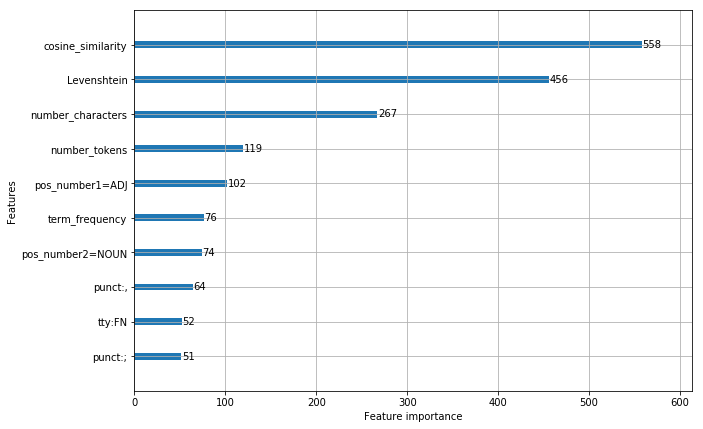

In [31]:
import lightgbm as lgb
import matplotlib.pyplot as plt

k = 10

print('Plotting feature importances...')
ax = lgb.plot_importance(lgbm, max_num_features=k, figsize=(10,7), importance_type='split', title='')
plt.show()

In [32]:
print(X_df.shape)
X_df.head()

(1571, 224)


,Levenshtein,abbrev_tty:False,abbrev_tty:True,cosine similarity,is np:False,is np:True,is np:not_available,is_pref,num_synsets,number characters,...,tty:PM,tty:PN,tty:PT,tty:PTCS,tty:PTGB,tty:PTN,tty:RT,tty:SD,tty:SY,tty:SYGB
0,18.0,1.0,0.0,0.642,0.0,0.0,1.0,0.0,1.0,25.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,18.0,1.0,0.0,0.627,0.0,0.0,1.0,0.0,1.0,25.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,18.0,1.0,0.0,0.478,0.0,0.0,1.0,0.0,1.0,22.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,12.0,1.0,0.0,0.650,0.0,0.0,1.0,0.0,1.0,23.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,13.0,1.0,0.0,0.475,0.0,0.0,1.0,0.0,1.0,28.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
from sklearn.model_selection import train_test_split
indices = range(0, X_df.shape[0])
print(len(indices))
X_train, X_dev, y_train, y_dev, indices_train, indices_test = train_test_split(X_df, y, indices,
                                                                               test_size=0.33,
                                                                               shuffle=True,
                                                                               random_state=42)
print(len(y_train), len(y_dev))

lgbm = LGBMClassifier(random_state=random_state,
                    boosting_type='gbdt', 
                    learning_rate=0.11,
                    num_leaves=31,
                    max_depth=-1,
                    reg_lambda=0)
lgbm.fit(X_train,y_train)

preds = lgbm.predict(X_dev)

recall = recall_score(y_dev, preds)
precision = precision_score(y_dev, preds)
f1 = f1_score(y_dev, preds)
print(precision, recall, f1)

print(confusion_matrix(y_dev, preds))

indices_error = [a==b for a, b in zip(y_dev, preds)]
error_mask = ~np.array(indices_error)
error_indices = np.array(indices_test)[error_mask]

1571
1052 519
0.8648648648648649 0.7191011235955056 0.7852760736196319
[[420  10]
 [ 25  64]]


In [34]:
def get_error_type(ab):
    a, b = ab
    if a>b:
        return 'FN'
    elif a<b:
        return 'FP'
    elif a==b==1:
        return 'TP'
    elif a==b==0:
        return 'TN'
    
    
#indices_error = [a==b for a, b in zip(y_dev, preds)]
error_type = [i for i in map(get_error_type, zip(y_dev, preds))]
error_type_errors = np.array(error_type)[error_mask]
print(len(error_type_errors))
print(error_type_errors)
pd.Series(error_type_errors).value_counts()

35
['FP' 'FN' 'FN' 'FN' 'FN' 'FN' 'FN' 'FN' 'FP' 'FN' 'FN' 'FN' 'FN' 'FN'
 'FN' 'FN' 'FP' 'FP' 'FN' 'FN' 'FN' 'FP' 'FP' 'FN' 'FN' 'FN' 'FN' 'FN'
 'FN' 'FP' 'FN' 'FN' 'FP' 'FP' 'FP']


FN    25
FP    10
dtype: int64

In [35]:
error_df = pd.DataFrame(term_cands.term_candidate.iloc[error_indices])
error_df['error_type'] = error_type_errors
print(error_df.shape)
error_df = error_df.sort_values(by='error_type')
error_df.head(error_df.shape[0])

(35, 2)


,term_candidate,error_type
1388,single episode major depressive disorder,FN
1280,premenstrual syndrome - pms,FN
1232,pms premenstrual syndrome,FN
1090,panic disorder [episodic paroxysmal anxiety],FN
1312,recurrent episode major depressive disorder,FN
743,episodic paroxysmal anxiety disorder,FN
705,dying fears,FN
931,mood disorder with depressive feature,FN
838,injection blood injury type phobia - fear of b...,FN
308,beck depression inventory (assessment scale),FN


# LOG REG

In [36]:
logreg = LogisticRegression(solver='liblinear', max_iter=300, penalty='l2', random_state=random_state)

logreg.fit(X,y)

important_feats = most_informative_features(feature_names, logreg, n=20)

	-2.1436	punct:,        		1.9239	is_pref        
	-2.1381	pos number3=ADJ		1.7783	pos number2=ADP
	-1.8718	punct:;        		1.4979	pos number4=PROPN
	-1.7451	tty:FN         		1.4437	tty:SY         
	-1.7378	pos number5=ADJ		1.3502	pos number1=ADJ
	-1.3595	pos number3=NOUN		1.2909	pos number1=PROPN
	-1.2667	tty:OAF        		1.2116	tty:PT         
	-1.2428	pos number3=PUNCT		1.1186	pos number6=NOUN
	-1.0857	pos number1=PUNCT		1.1163	punct:no_punct 
	-1.0654	pos number6=ADJ		1.0011	pos number4=NOUN
	-1.0564	pos number3=PROPN		0.9454	is np:True     
	-1.0254	pos number2=ADJ		0.8632	tty:OAS        
	-1.0251	is np:not_available		0.8629	part of np:True
	-1.0251	part of np:not_available		0.7532	pos number5=NOUN
	-1.0152	abbrev_tty:True		0.7476	pos number1=X  
	-1.0028	pos number2=VERB		0.7387	tty:FI         
	-0.9782	tty:IS         		0.6944	abbrev_tty:False
	-0.8568	tty:HX         		0.6703	pos number5=VERB
	-0.8389	source:CHV     		0.6577	pos number2=PROPN
	-0.8158	cosine similarity		0.6238	tt

In [37]:
imp_feats = pd.DataFrame(important_feats)
imp_feats.columns = ['importance', 'feature']
imp_feats['score'] = imp_feats.importance.apply(lambda x: abs(x))
imp_feats.head()

,importance,feature,score
0,-2.143644,"punct:,",2.143644
1,-2.138105,pos number3=ADJ,2.138105
2,-1.871818,punct:;,1.871818
3,-1.745140,tty:FN,1.745140
4,-1.737779,pos number5=ADJ,1.737779


In [38]:
imp_feats = imp_feats.sort_values(by='score', ascending=False)
imp_feats.head()

,importance,feature,score
0,-2.143644,"punct:,",2.143644
1,-2.138105,pos number3=ADJ,2.138105
223,1.923928,is_pref,1.923928
2,-1.871818,punct:;,1.871818
222,1.778323,pos number2=ADP,1.778323


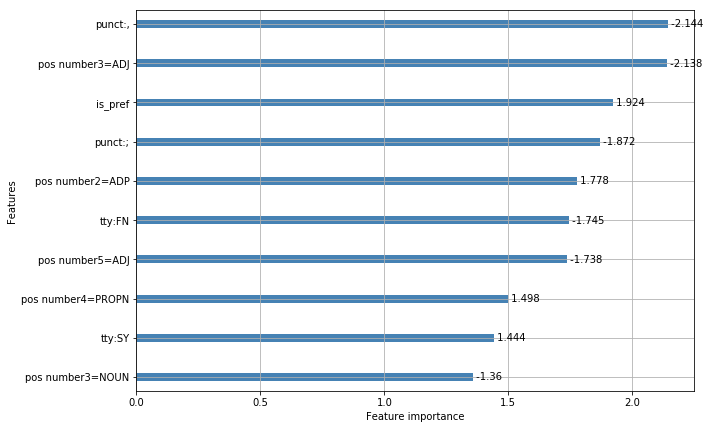

In [39]:
% matplotlib inline

data = imp_feats[['score', 'feature', 'importance']].reset_index(drop=True)
data.score = data.score.astype(float)


data= data.head(k).sort_values(by='score')

ax = data.plot(y="score", x="feature", kind="barh",
          color='steelblue', grid=True, legend=False,
          figsize=(10,7), use_index=True, width=0.2)

ax.set_xlabel("Feature importance")
ax.set_ylabel("Features")

for i, v in enumerate(data.importance):
    ax.text(abs(v), i, " "+str(round(v,3)), color='black', va='center', fontweight='regular') 




In [40]:
xgb = XGBClassifier(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

xgb.fit(X,y)

#y_ = xgb.predict(X)
#y_.shape

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=10,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

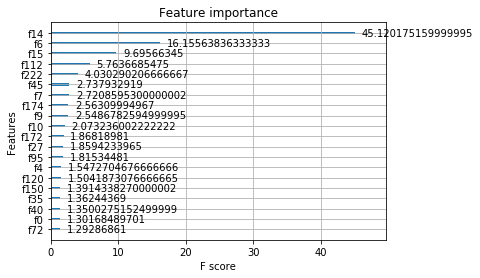

In [41]:
% matplotlib inline

import xgboost

xgboost.plot_importance(xgb, max_num_features=20, importance_type='gain')

In [42]:
#help(xgboost.plot_importance)

In [43]:
X = np.array(X)
cat = CatBoostClassifier(iterations=2, depth=2, learning_rate=1, loss_function='Logloss', logging_level='Verbose')
cat.fit(X,y)

0:	learn: 0.3277978	total: 70.3ms	remaining: 70.3ms
1:	learn: 0.3102657	total: 87.9ms	remaining: 0us


In [44]:
import shap
# load JS visualization code to notebook
shap.initjs()

In [45]:
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X)

In [46]:
# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[1,:], X[1,:])

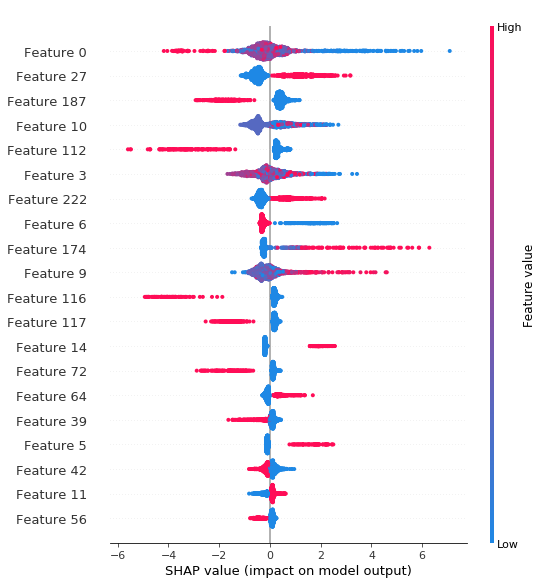

In [47]:
shap.summary_plot(shap_values, X)

In [48]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor()
gbr.fit(X,y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

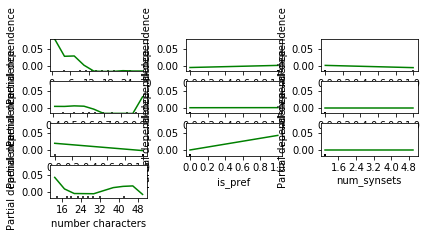

In [49]:
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

my_plots = plot_partial_dependence(gbr,       
                                   features=[i for i in range(10)], # column numbers of plots we want to show
                                   X=X,            # raw predictors data.
                                   feature_names=feature_names, # labels on graphs
                                   grid_resolution=10) # number of values to plot on x axis

In [50]:
feature_names = dict_vec.feature_names_
print(feature_names)

['Levenshtein', 'abbrev_tty:False', 'abbrev_tty:True', 'cosine similarity', 'is np:False', 'is np:True', 'is np:not_available', 'is_pref', 'num_synsets', 'number characters', 'number tokens', 'obsolete_tty:False', 'obsolete_tty:True', 'part of np:False', 'part of np:True', 'part of np:not_available', 'pos number10=ADP', 'pos number10=NOUN', 'pos number10=NUM', 'pos number10=PUNCT', 'pos number10=VERB', 'pos number11=NOUN', 'pos number11=PUNCT', 'pos number11=SYM', 'pos number12=NUM', 'pos number12=PUNCT', 'pos number13=PUNCT', 'pos number1=ADJ', 'pos number1=ADP', 'pos number1=ADV', 'pos number1=CCONJ', 'pos number1=DET', 'pos number1=INTJ', 'pos number1=NOUN', 'pos number1=NUM', 'pos number1=PROPN', 'pos number1=PUNCT', 'pos number1=VERB', 'pos number1=X', 'pos number2=ADJ', 'pos number2=ADP', 'pos number2=ADV', 'pos number2=NOUN', 'pos number2=NUM', 'pos number2=PROPN', 'pos number2=PUNCT', 'pos number2=SYM', 'pos number2=VERB', 'pos number2=X', 'pos number3=ADJ', 'pos number3=ADP', 

In [51]:
help(dict_vec)

Help on DictVectorizer in module sklearn.feature_extraction.dict_vectorizer object:

class DictVectorizer(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin)
 |  Transforms lists of feature-value mappings to vectors.
 |  
 |  This transformer turns lists of mappings (dict-like objects) of feature
 |  names to feature values into Numpy arrays or scipy.sparse matrices for use
 |  with scikit-learn estimators.
 |  
 |  When feature values are strings, this transformer will do a binary one-hot
 |  (aka one-of-K) coding: one boolean-valued feature is constructed for each
 |  of the possible string values that the feature can take on. For instance,
 |  a feature "f" that can take on the values "ham" and "spam" will become two
 |  features in the output, one signifying "f=ham", the other "f=spam".
 |  
 |  However, note that this transformer will only do a binary one-hot encoding
 |  when feature values are of type string. If categorical features are
 |  represented as numeric values s